
📝 Testing text field: title


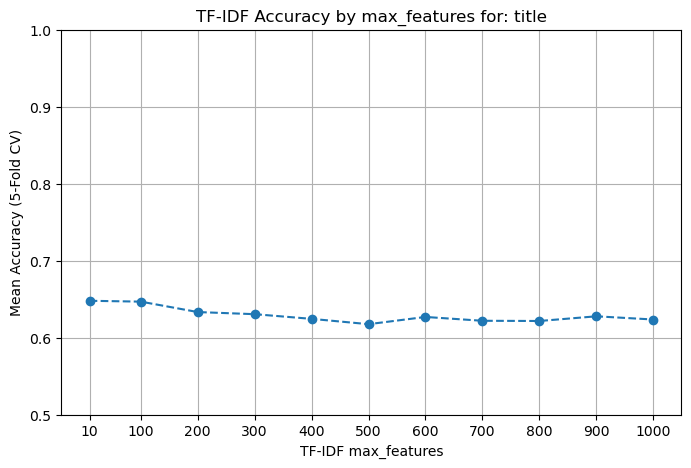


📝 Testing text field: title+abstract


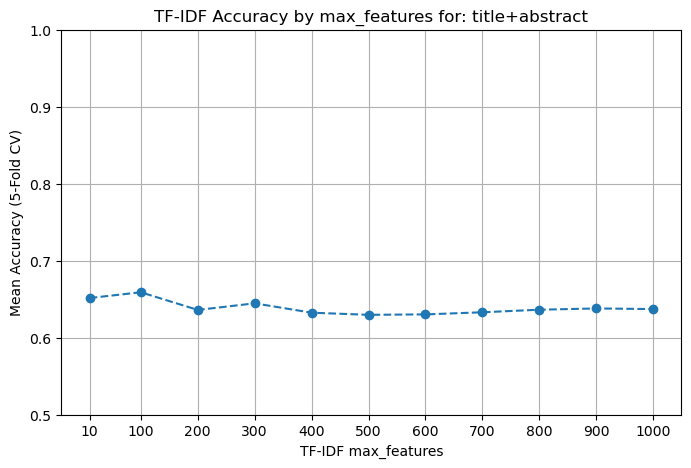


📝 Testing text field: title+abstract+introduction


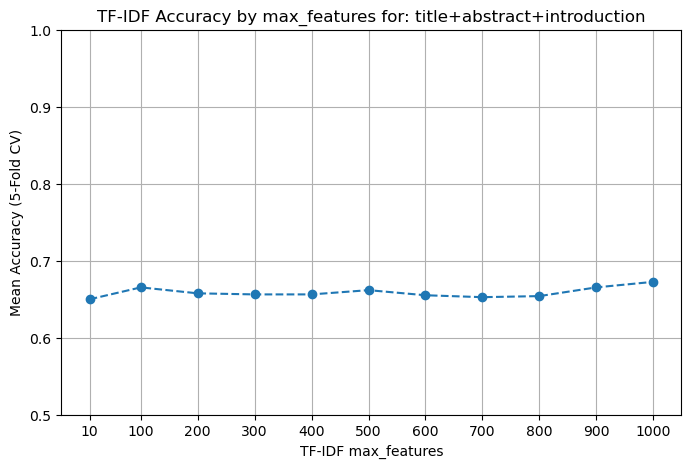


📝 Testing text field: title+abstract+introduction+conclusion


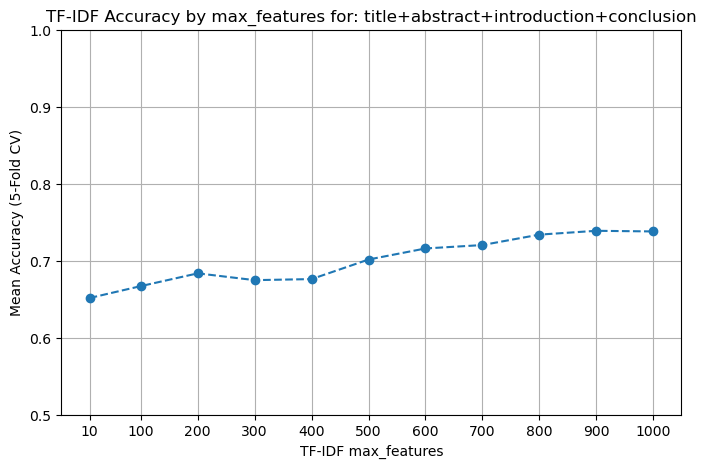


📝 Testing text field: title+abstract+conclusion


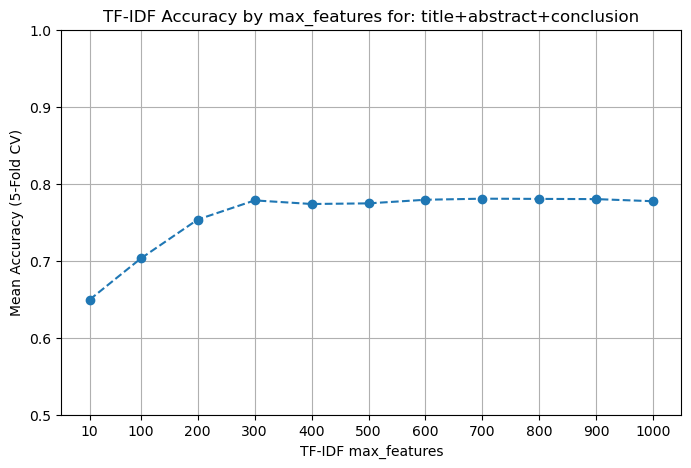


📝 Testing text field: title+introduction+conclusion


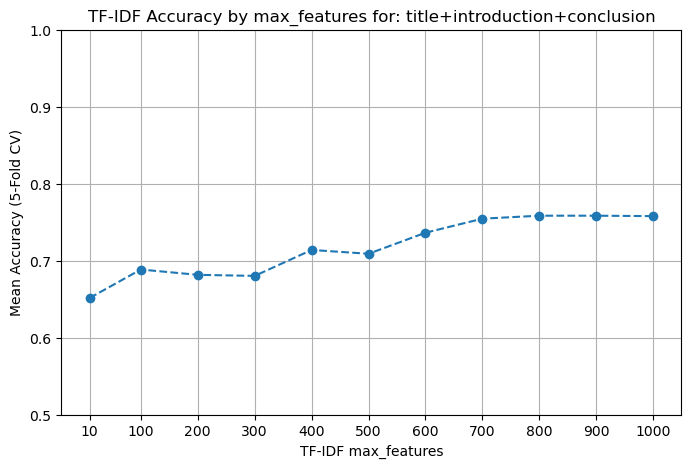


📊 全部字段组合下的准确率:

📘 title:
  max_features=10: Accuracy=0.6478
  max_features=100: Accuracy=0.6467
  max_features=200: Accuracy=0.6331
  max_features=300: Accuracy=0.6304
  max_features=400: Accuracy=0.6243
  max_features=500: Accuracy=0.6174
  max_features=600: Accuracy=0.6268
  max_features=700: Accuracy=0.6218
  max_features=800: Accuracy=0.6215
  max_features=900: Accuracy=0.6276
  max_features=1000: Accuracy=0.6235

📘 title+abstract:
  max_features=10: Accuracy=0.6514
  max_features=100: Accuracy=0.6588
  max_features=200: Accuracy=0.6359
  max_features=300: Accuracy=0.6445
  max_features=400: Accuracy=0.6323
  max_features=500: Accuracy=0.6296
  max_features=600: Accuracy=0.6301
  max_features=700: Accuracy=0.6329
  max_features=800: Accuracy=0.6362
  max_features=900: Accuracy=0.6378
  max_features=1000: Accuracy=0.6370

📘 title+abstract+introduction:
  max_features=10: Accuracy=0.6497
  max_features=100: Accuracy=0.6652
  max_features=200: Accuracy=0.6575
  max_features=300: Accu

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# === 1. 读取 CSV 文件 ===
file_path = r"E:\judita's project\new data\paper_id_intro_conclusion_combined_final.csv"  # 修改为你的实际路径
df = pd.read_csv(file_path, encoding="utf-8")

# === 2. 保留 numeric 特征和 categorical 特征（不做任何更改）===
numeric = df[["page_count", "citation_count", "figure_count", "table_count", "section_count", "reference_count"]]
#categorical = df[["publication", "year"]]
y = df["decision"].values  # 假设标签列为 "decision"

# === 3. 平衡数据（可选，如果不需要平衡可以注释掉）===
df_accept = df[df["decision"] == 1]
df_reject = df[df["decision"] == 0].sample(n=len(df_accept), random_state=42)
df_balanced = pd.concat([df_accept, df_reject]).sample(frac=1, random_state=42).reset_index(drop=True)

# 替换 numeric/categorical/y 为平衡后的
numeric = df_balanced[["page_count", "citation_count", "figure_count", "table_count", "section_count", "reference_count"]]
#categorical = df_balanced[["publication", "year"]]
y = df_balanced["decision"].values

# === 4. 预处理 numeric & categorical 特征 ===
X_numeric_scaled = StandardScaler().fit_transform(numeric)
#X_categorical_encoded = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit_transform(categorical)

# === 5. 文本字段组合列表（可选使用你想要的）===
text_fields = [
    "title",
    "title+abstract",
    "title+abstract+introduction",
    "title+abstract+introduction+conclusion",
    "title+abstract+conclusion",
    "title+introduction+conclusion"
]

# === 6. TF-IDF 训练 ===
k_list = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for field in text_fields:
    print(f"\n📝 Testing text field: {field}")
    text = df_balanced[field].astype(str)
    accuracy_dict = {}

    for k in k_list:
        tfidf = TfidfVectorizer(max_features=k, ngram_range=(1, 2), stop_words='english', min_df=2, max_df=0.85)
        X_text = tfidf.fit_transform(text).toarray()
        X_combined = np.hstack([X_text, X_numeric_scaled])#, X_categorical_encoded])

        accs = []
        for train_idx, test_idx in skf.split(X_combined, y):
            X_train, X_test = X_combined[train_idx], X_combined[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = SVC(kernel='linear', random_state=42)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            accs.append(accuracy_score(y_test, y_pred))

        accuracy_dict[k] = accs

    # 存储平均准确率
    avg_acc = {k: np.mean(v) for k, v in accuracy_dict.items()}
    results[field] = avg_acc

    # 可视化
    plt.figure(figsize=(8, 5))
    plt.plot(list(avg_acc.keys()), list(avg_acc.values()), marker='o', linestyle='--')
    plt.title(f"TF-IDF Accuracy by max_features for: {field}")
    plt.xlabel("TF-IDF max_features")
    plt.ylabel("Mean Accuracy (5-Fold CV)")
    plt.grid(True)
    plt.xticks(k_list)
    plt.ylim(0.5, 1.0)
    plt.show()

# === 7. 输出全部平均准确率结果 ===
print("\n📊 全部字段组合下的准确率:")
for field in text_fields:
    print(f"\n📘 {field}:")
    for k in k_list:
        print(f"  max_features={k}: Accuracy={results[field][k]:.4f}")
